# Cornerstone Project - Final Report
### Zillow's Zestimate Error Prediction

Kaggle link: https://www.kaggle.com/c/zillow-prize-1/data

You will need an Kaggle account to access the data. If you don't, you can download from my Onedrive folder: https://1drv.ms/f/s!Ag8gYdQmsTrfiroGfEXBH0lMwD8b-Q

#### Project Overview

The problem is first raised by Zillow on Kaggle. Zillow, a home price valuation company, provides the datasets for people to analyze and start with. The goal is to predict of Zillow's logerrors = log(Zestimate) – log(Sale Price). Zestimates, like the name indicates, are values of home estimated by Zillow based on statistical and machine learning models. 

In other words, this project is not to predict home value for Zillow, but to analyze how wrong Zellow's predictions are. The project is to help Zillow identify and minimize Mean Absolute Error between the predicted log error (predicted error by the project) and the actual log error (Zillow’s prediction error).

#### Target Audience
The output will help Zillow to identify and reduce prediction errors, and provide more accurate home value estimation.

#### File Descriptions
There are four datasets provided by Zillow of two kinds. The properties data contains all the home features of the properties, and training data contains all the transaction information of each year. The properties are from three counties: Los Angeles, Orange, and Ventura, CA.

properties_2016.csv – all the properties with their home features for 2016
properties_2017.csv – all the properties with their home features for 2017
train_2016.csv – the training set with transactions from 1/1/2016 to 12/31/2016
train_2017.csv – the training set with transactions from 1/1/2017 to 9/15/2017

The properties datasets provide 58 features, such as the floor plan, building class type, garage size, pool count, year build, location, tax amount, etc. There are plenty of nulls in some columns.

---
# 1. Importing & Merging Data

#### Import packages

In [181]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

#### Set data directory

In [182]:
data_dir = '/Users/Zhang/OneDrive/Data/Zillow_Data/'

#### Import data

In [183]:
properties_2016 = pd.read_csv(data_dir + 'properties_2016.csv')
properties_2017 = pd.read_csv(data_dir + 'properties_2017.csv')
train_2016 = pd.read_csv(data_dir + 'train_2016.csv')
train_2017 = pd.read_csv(data_dir + 'train_2017.csv')

#### Test if rows in each dataset have unique parcelid

In [184]:
print('# of parcelid\'s in properties_2016.csv: ' + str(len(properties_2016.parcelid)))
print('# of parcelid\'s in properties_2017.csv: ' + str(len(properties_2017.parcelid)))
print('# of unique parcelid\'s in properties_2016.csv: ' + str(len(set(properties_2016.parcelid))))
print('# of unique parcelid\'s in properties_2017.csv: ' + str(len(set(properties_2017.parcelid))))

print('\n# of parcelid\'s in train_2016.csv: ' + str(len(train_2016.parcelid)))
print('# of parcelid\'s in train_2017.csv: ' + str(len(train_2017.parcelid)))
print('# of unique parcelid\'s in train_2016.csv: ' + str(len(set(train_2016.parcelid))))
print('# of unique parcelid\'s in train_2017.csv: ' + str(len(set(train_2017.parcelid))))

# of parcelid's in properties_2016.csv: 2985217
# of parcelid's in properties_2017.csv: 2985217
# of unique parcelid's in properties_2016.csv: 2985217
# of unique parcelid's in properties_2017.csv: 2985217

# of parcelid's in train_2016.csv: 90275
# of parcelid's in train_2017.csv: 77613
# of unique parcelid's in train_2016.csv: 90150
# of unique parcelid's in train_2017.csv: 77414


The parcelid of each row in Properties is unique.
Rows in Train share same parcelid, because some properties are sold multiple times in one year.

#### Test whether the parcelid's in Properties_2016 and Properties_2017 are the same

In [185]:
test = pd.concat([properties_2016, properties_2017])
test.sort_index(inplace=True)

sub1 = test.index[:-1].tolist()
sub2 = test.index[1:].tolist()

mask = [sub1[i] != sub2[i] for i in range(len(sub1))]
mask.append(True)

- The # of unique parcelid in the joint file from two Properties datasets is 2985217

- Thus the two datasets have same set of parcelid.

- In other words, the data are from the same properties.

#### Merge the Properties data w/ Train data of respective year

In [186]:
merged_2016 = train_2016.join(properties_2016.set_index('parcelid'), on='parcelid')
merged_2017 = train_2017.join(properties_2017.set_index('parcelid'), on='parcelid')

print('- The merged 2016 dataset has ' + str(merged_2016.shape[0]) + ' rows and ' + \
      str(merged_2016.shape[1]) + ' columns')
print('- The merged 2017 dataset has ' + str(merged_2017.shape[0]) + ' rows and ' + \
      str(merged_2017.shape[1]) + ' columns')

- The merged 2016 dataset has 90275 rows and 60 columns
- The merged 2017 dataset has 77613 rows and 60 columns


#### Concatenate the merged data

In [187]:
merged = pd.concat([merged_2016, merged_2017])
merged.transactiondate = pd.to_datetime(merged.transactiondate)
merged.sort_values(by=['transactiondate'], inplace=True)
merged.to_csv(data_dir + 'merged.csv')

print('There are ' + str(len(merged.parcelid)) + ' transactions associated w/ ' \
      + str(len(set(merged.parcelid))) + ' properties from 1/1/2016 to 9/25/2017.\n')

There are 167888 transactions associated w/ 165210 properties from 1/1/2016 to 9/25/2017.



---
# 2. Data Preparation

#### Data types of the feature columns

In [188]:
types = merged.dtypes
print(types)

parcelid                                 int64
logerror                               float64
transactiondate                 datetime64[ns]
airconditioningtypeid                  float64
architecturalstyletypeid               float64
basementsqft                           float64
bathroomcnt                            float64
bedroomcnt                             float64
buildingclasstypeid                    float64
buildingqualitytypeid                  float64
calculatedbathnbr                      float64
decktypeid                             float64
finishedfloor1squarefeet               float64
calculatedfinishedsquarefeet           float64
finishedsquarefeet12                   float64
finishedsquarefeet13                   float64
finishedsquarefeet15                   float64
finishedsquarefeet50                   float64
finishedsquarefeet6                    float64
fips                                   float64
fireplacecnt                           float64
fullbathcnt  

- Most of the columns are float. Some columns are strings. (object type)

- Some int/float columns should be treated as strings (e.g. the ones ending w/ "id").

#### Find features that are categorical

In [189]:
# Find columns containing 'id'
str_cols = [col for col in merged.columns if 'id' in col]

# Add other columns looking like string
str_cols.append('fips')
str_cols.append('rawcensustractandblock')
str_cols.append('censustractandblock')

#### Identify nulls

In [190]:
# Print first 5 rows of data
merged.head()

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1.0,NaN,NaN,2.0,3.0,NaN,4.0,...,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,-0.1684,2016-01-01,NaN,NaN,NaN,3.5,4.0,NaN,NaN,...,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,1.0,NaN,NaN,3.0,2.0,NaN,4.0,...,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13
3,12643413,0.0218,2016-01-02,1.0,NaN,NaN,2.0,2.0,NaN,4.0,...,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13
4,14432541,-0.0050,2016-01-02,NaN,NaN,NaN,2.5,4.0,NaN,NaN,...,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13


In [191]:
merged.describe()

,parcelid,logerror,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,yardbuildingsqft26,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock
count,1.678880e+05,167888.000000,53788.000000,468.000000,93.000000,167854.000000,167854.000000,31.000000,107173.000000,166056.000000,...,165.000000,166828.000000,38169.000000,1.673590e+05,1.678520e+05,167854.000000,1.678510e+05,167843.000000,4683.000000,1.670020e+05
mean,1.299536e+07,0.013906,1.814345,7.299145,695.376344,2.288265,3.041739,3.967742,6.015461,2.312542,...,271.260606,1968.569311,1.437764,1.843460e+05,4.726833e+05,2015.462181,2.888805e+05,5989.515575,13.827247,6.049390e+13
std,3.016071e+06,0.165706,2.970239,2.719633,583.952144,1.000835,1.149134,0.179605,1.882799,0.977808,...,293.611447,23.777202,0.544508,2.192841e+05,6.028372e+05,0.498569,4.456451e+05,7214.731946,2.421658,1.054137e+12
min,1.071174e+07,-4.655420,1.000000,2.000000,38.000000,0.000000,0.000000,3.000000,1.000000,1.000000,...,12.000000,1824.000000,1.000000,4.400000e+01,2.200000e+01,2015.000000,2.200000e+01,19.920000,3.000000,6.037101e+13
25%,1.154899e+07,-0.025300,1.000000,7.000000,280.000000,2.000000,2.000000,4.000000,4.000000,2.000000,...,88.000000,1953.000000,1.000000,8.256800e+04,2.026522e+05,2015.000000,8.373000e+04,2798.070000,13.000000,6.037312e+13
50%,1.254060e+07,0.006000,1.000000,7.000000,588.000000,2.000000,3.000000,4.000000,7.000000,2.000000,...,160.000000,1970.000000,1.000000,1.340510e+05,3.500000e+05,2015.000000,1.977760e+05,4501.040000,14.000000,6.037604e+13
75%,1.421930e+07,0.039200,1.000000,7.000000,819.000000,3.000000,4.000000,4.000000,7.000000,3.000000,...,320.000000,1987.000000,2.000000,2.142570e+05,5.540020e+05,2016.000000,3.553340e+05,6914.165000,15.000000,6.059042e+13
max,1.676893e+08,5.262999,13.000000,21.000000,3560.000000,20.000000,16.000000,4.000000,12.000000,20.000000,...,1366.000000,2016.000000,6.000000,1.142179e+07,4.906124e+07,2016.000000,4.895220e+07,586639.300000,99.000000,4.830301e+14


Some columns have too few non-nulls. Later we will explore these columns first. If they are not important, we will remove them.

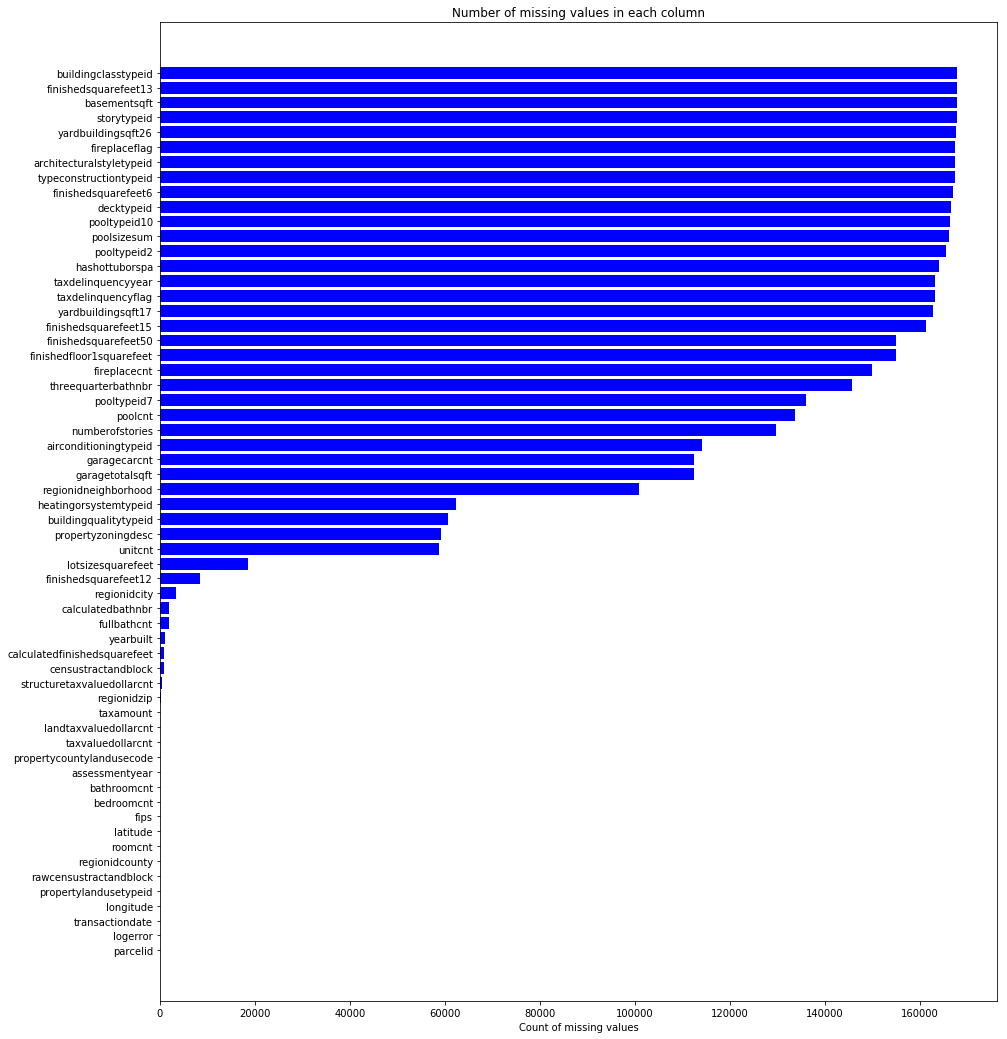

In [192]:
missing_df = merged.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
#missing_df = missing_df.ix[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(15,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

----
# 3. Exploratory Analysis

## Target variable

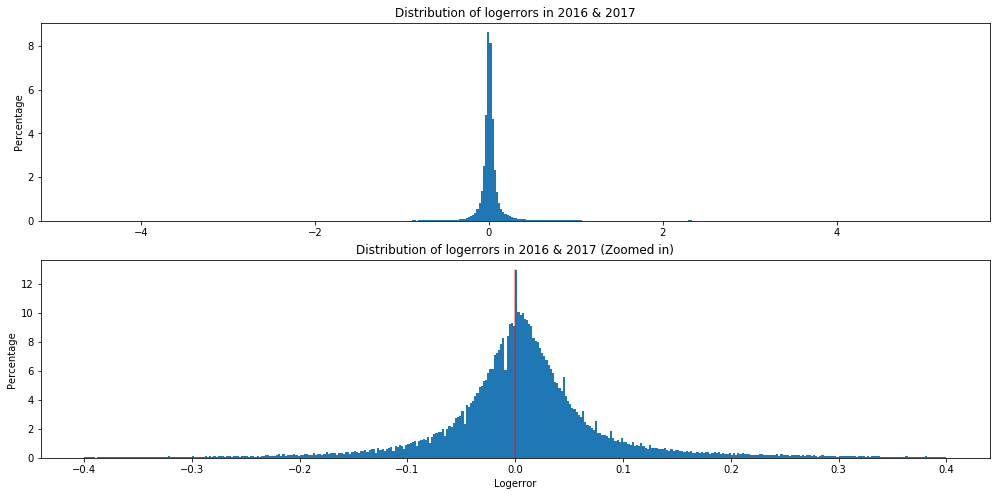

99% of logerrors are between (-0.49, 0.76), but there are outliers, such as max = 5.26 & min = -4.66


In [193]:
# Description of logerror
le_des = merged.logerror.describe()

# Find the range of 99% of logerrors
range_99 = np.percentile(merged.logerror, [.5, 99.5])

# Bins of histogram
bins = 400 # ~= int(np.sqrt(len(merged)))

# Histogram of logerrors
plt.figure(figsize=(17, 8))
plt.subplot(2, 1, 1)
plt.hist(merged.logerror, bins=bins, normed=True)
plt.xlabel('')
plt.ylabel('Percentage')
plt.title('Distribution of logerrors in 2016 & 2017')

# Zoomed histogram of logerrors
plt.subplot(2, 1, 2)
plt.hist(merged.logerror, bins=bins, normed=True, range=[-.4, .4])
plt.plot([0, 0], [0, 13], color='r', alpha=.5)
plt.xlabel('Logerror')
plt.ylabel('Percentage')
plt.title('Distribution of logerrors in 2016 & 2017 (Zoomed in)')

plt.show()

print('99% of logerrors are between (' + str(round(range_99[0], 2)) + ', ' + \
      str(round(range_99[1], 2)) + '), but there are outliers, such as max = ' + \
      str(round(le_des['max'], 2)) + ' & min = ' + str(round(le_des['min'], 2)))


- The logerrors are highly concentrated around zero. Most of them are between -.2 and .2.

- The distribution is slightly skewed to the right and has a faintly positive mean.

- The distribution has single peak and thin tails.

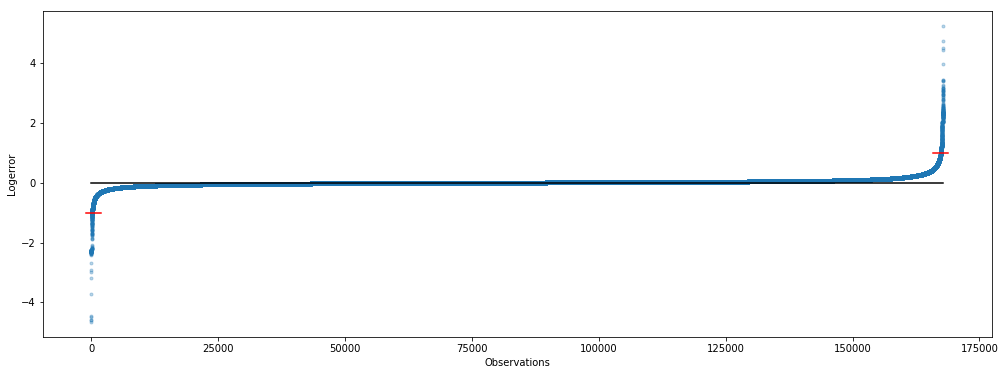

In [194]:
plt.figure(figsize=(17,6))
plt.scatter(range(merged.shape[0]), np.sort(merged.logerror.values), marker='.', alpha=0.3)
plt.plot([0, merged.shape[0]], [0, 0], c='black')
plt.plot([-1000, 2000], [-1, -1], c='r')
plt.plot([merged.shape[0]-2000, merged.shape[0]+1000], [1, 1], c='r')
plt.xlabel('Observations')
plt.ylabel('Logerror')
plt.show()

The scatterplot shows that most log errors are around zero. There are very few outliers so we will identify and focus on the outliers.

In [195]:
abs_pct_95 = abs(merged.logerror).quantile(.95)
outliers = merged[abs(merged.logerror) > abs_pct_95]
outliers_1 = merged[abs(merged.logerror) > 1]

print('95th percentile of the absolute values of logerrors: ' + str(abs_pct_95))
print('# logerrors larger than ' + str(abs_pct_95) + ': ' +str(len(outliers)))
print('# logerrors larger than 1.000: '+str(len(outliers_1)))

95th percentile of the absolute values of logerrors: 0.237
# logerrors larger than 0.237: 8391
# logerrors larger than 1.000: 694


We will focus on the 8391 observations of large logerrors, w/ close attention to the 694 outliers larger than 1.

## Predictor variables

### Feature categorization
#### Define numerical, categorical and special features

In [196]:
count = merged.apply(pd.Series.count)
nunique = merged.apply(pd.Series.nunique)
nunique_count = pd.DataFrame([nunique, count, round(count/167888*100, 2)]).T
nunique_count.columns = ['n_unique', 'n_nonmissing', 'pct_nonmissing']
nunique_count

,n_unique,n_nonmissing,pct_nonmissing
parcelid,165210.0,167888.0,100.00
logerror,78958.0,167888.0,100.00
transactiondate,616.0,167888.0,100.00
airconditioningtypeid,6.0,53788.0,32.04
architecturalstyletypeid,6.0,468.0,0.28
basementsqft,78.0,93.0,0.06
bathroomcnt,25.0,167854.0,99.98
bedroomcnt,17.0,167854.0,99.98
buildingclasstypeid,2.0,31.0,0.02
buildingqualitytypeid,12.0,107173.0,63.84


After looking through the # of unique values, # of missing values, and the values, we classify the features into three types: numerical, categorical, and special.

- For numerical features, we will plot scatter plot and identify trends;
- For categorical features, we will create dummy vars and calculate correlations;
- For special type features, we will handle case by case.

The below are special type features, all other features will be either numerical or categorical:
- transactiondate
- taxdelinquencyyear
- censustractandblock
- rawcensustractandblock
- longitude
- latitude

In [197]:
numerical_var = [
'fireplacecnt',
'threequarterbathnbr',
'numberofstories',
'garagecarcnt',
'fullbathcnt',
'bedroomcnt',
'finishedsquarefeet13',
'roomcnt',
'calculatedbathnbr',
'bathroomcnt',
'basementsqft',
'yardbuildingsqft26',
'poolsizesum',
'finishedsquarefeet6',
'yardbuildingsqft17',
'garagetotalsqft',
'finishedfloor1squarefeet',
'finishedsquarefeet50',
'finishedsquarefeet15',
'finishedsquarefeet12',
'calculatedfinishedsquarefeet',
'lotsizesquarefeet',
'structuretaxvaluedollarcnt',
'taxvaluedollarcnt',
'landtaxvaluedollarcnt',
'taxamount',
'yearbuilt',
'longitude',
'latitude'
]

categorical_var = [
'decktypeid',
'hashottuborspa',
'poolcnt',
'pooltypeid10',
'pooltypeid2',
'pooltypeid7',
'storytypeid',
'fireplaceflag',
'taxdelinquencyflag',
'buildingclasstypeid',
'assessmentyear',
'fips',
'regionidcounty',
'typeconstructiontypeid',
'airconditioningtypeid',
'architecturalstyletypeid',
'buildingqualitytypeid',
'heatingorsystemtypeid',
'unitcnt',
'propertylandusetypeid',
'propertycountylandusecode',
'propertyzoningdesc',
'regionidcity',
'regionidzip',
'regionidneighborhood',
]

#### Missing value handling
Based on the intrinsic nature of each feature, we will make educated guess about the missing values (False, 0, mean or missing)

In [198]:
merged[numerical_var].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167888 entries, 0 to 77612
Data columns (total 29 columns):
fireplacecnt                    17896 non-null float64
threequarterbathnbr             22115 non-null float64
numberofstories                 38169 non-null float64
garagecarcnt                    55457 non-null float64
fullbathcnt                     166056 non-null float64
bedroomcnt                      167854 non-null float64
finishedsquarefeet13            75 non-null float64
roomcnt                         167854 non-null float64
calculatedbathnbr               166056 non-null float64
bathroomcnt                     167854 non-null float64
basementsqft                    93 non-null float64
yardbuildingsqft26              165 non-null float64
poolsizesum                     1838 non-null float64
finishedsquarefeet6             807 non-null float64
yardbuildingsqft17              5039 non-null float64
garagetotalsqft                 55457 non-null float64
finishedfloor1squ

In [199]:
merged[categorical_var].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167888 entries, 0 to 77612
Data columns (total 25 columns):
decktypeid                   1272 non-null float64
hashottuborspa               3904 non-null object
poolcnt                      34075 non-null float64
pooltypeid10                 1626 non-null float64
pooltypeid2                  2278 non-null float64
pooltypeid7                  31776 non-null float64
storytypeid                  93 non-null float64
fireplaceflag                394 non-null object
taxdelinquencyflag           4683 non-null object
buildingclasstypeid          31 non-null float64
assessmentyear               167854 non-null float64
fips                         167854 non-null float64
regionidcounty               167854 non-null float64
typeconstructiontypeid       522 non-null float64
airconditioningtypeid        53788 non-null float64
architecturalstyletypeid     468 non-null float64
buildingqualitytypeid        107173 non-null float64
heatingorsystemtypeid 

In [200]:
df = merged.copy()

# Fill NaN w/ zeros (for columns that we believe NaN stands for Not Applicable)
df['poolcnt'] = df['poolcnt'].fillna(0) # 133813 out of 167888 observations (80%) are nulls; the ratio makes sense as most homes do not have a pool
df['fireplacecnt'] = df['fireplacecnt'].fillna(0) # 149992/167888 (90%) are nulls; the ratio makes sense as fireplace is rarely seen in most houses
df['garagecarcnt'] = df['garagecarcnt'].fillna(0) # 112431/16788 (67%) are nulls; the ratio makes sense as apartments/condos do not have garage
df['yardbuildingsqft17'] = df['yardbuildingsqft17'].fillna(0) # 162849/16788 (97%) are nulls; 
df['taxdelinquencyyear'] = df['taxdelinquencyyear'].fillna(0)

# Imply poolsizesum from poolcnt
mask_mean = (df['poolcnt'] == 1 & np.isnan(df['poolsizesum'])) # mask of pool count >= 1 but size missing => fill w/ mean
mask_0 = (df['poolcnt'] == 0 & np.isnan(df['poolsizesum'])) # mask of pool count = 0 and size missing => fill w/ 0
df['poolsizesum'][mask_mean] = merged['poolsizesum'].mean()
df['poolsizesum'][mask_0] = 0.0

# Fill NaN with means in numerical parameters using Imputer
X =  df[numerical_var]
imp = preprocessing.Imputer(missing_values='NaN', strategy='mean', axis=0)
imp = imp.fit(X)
X_imp = imp.transform(X)
df[numerical_var] = X_imp

# Fill NaN w/ "missing" in categorical parameters
df[categorical_var] = df[categorical_var].fillna('missing')

#### Preprocessing

In [201]:
# Standardize numerical parameters
df[numerical_var] = preprocessing.scale(df[numerical_var])

# Convert to boolean type (for columns that have only one value)
df['decktypeid'] = df['decktypeid'].fillna(False).astype('bool')
df['hashottuborspa'] = df['hashottuborspa'].fillna(False)
df['pooltypeid10'] = df['pooltypeid10'].astype('bool')
df['pooltypeid2'] = df['pooltypeid2'].astype('bool')
df['pooltypeid7'] = df['pooltypeid7'].astype('bool')
df['storytypeid'] = df['storytypeid'].fillna(False).astype('bool')
df['fireplaceflag'] = df['fireplaceflag'].fillna(False)
df['taxdelinquencyflag'] = df['taxdelinquencyflag'].fillna(False).astype('bool')

# Convert to category type
categorize_label = lambda x: x.astype('category')
df[categorical_var] = df[categorical_var].apply(categorize_label)
#print(df[numerical_var].dtypes)
#print(df[categorical_var].dtypes)

# Re-extract outliers
outliers = df[abs(df.logerror) > abs_pct_95]
outliers_1 = df[abs(df.logerror) > 1]

### Transaction date
We start with transaction date, as it has no missing data and can give us some sense of how Zillow perform over time.

#### Logerror by time

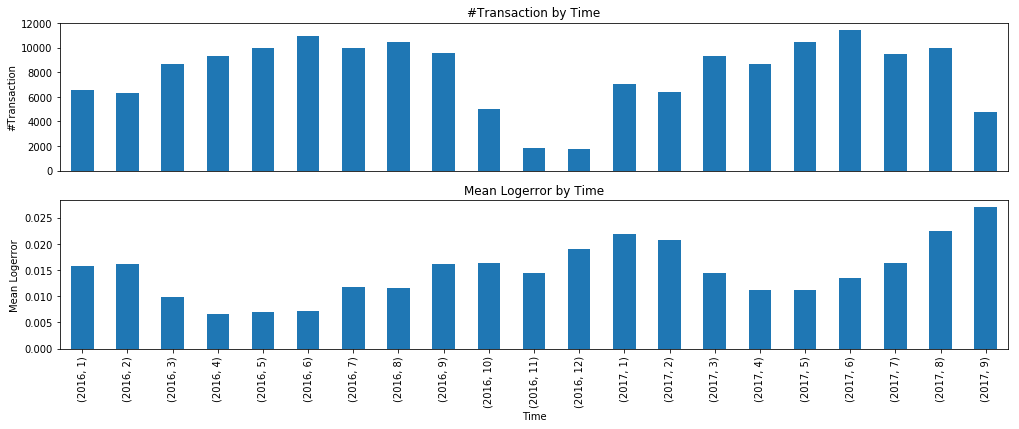

In [202]:
grouped = df['logerror'].groupby([df["transactiondate"].dt.year, df["transactiondate"].dt.month])

plt.figure(figsize=(17, 6))

plt.subplot(2, 1, 1)
grouped.count().plot(kind='bar')
plt.xticks([])
plt.xlabel(' ')
plt.ylabel('#Transaction')
plt.title('#Transaction by Time')

plt.subplot(2, 1, 2)
grouped.mean().plot(kind='bar')
plt.xlabel('Time')
plt.ylabel('Mean Logerror')
plt.title('Mean Logerror by Time')

plt.show()

- The #transaction decline during winter

- More #transactions come with more accuracy (smaller logerror)

- The mean logerror is increasing overtime

- Mean logerrors are lower during spring (March - June)

#### Logerror by month

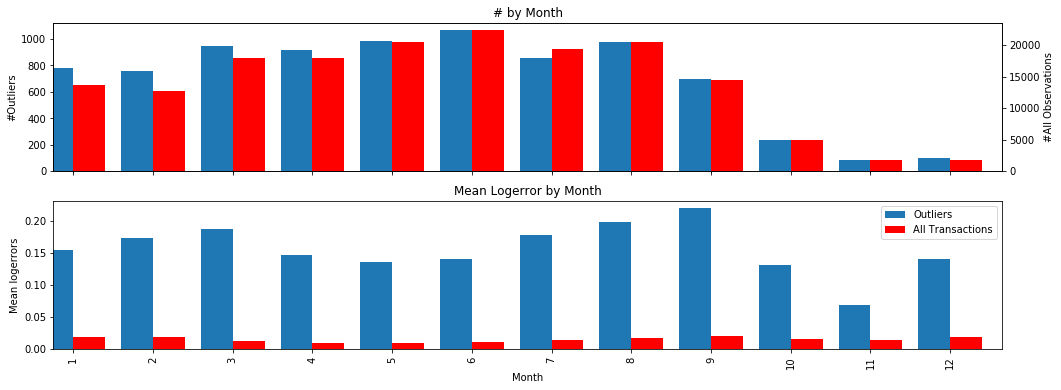

In [203]:
fig = plt.figure(figsize=(17, 6)) # Create matplotlib figure

ax = fig.add_subplot(211) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.
outliers['logerror'].groupby(outliers["transactiondate"].dt.month).count().plot(kind='bar', ax=ax, width=.4, position=1)
df['logerror'].groupby(df["transactiondate"].dt.month).count().plot(kind='bar', ax=ax2, width=.4, position=0, color='r')
ax.set_xlabel(' ')
ax.set_ylabel('#Outliers')
ax2.set_ylabel('#All Observations')
plt.title('# by Month')

ax3 = fig.add_subplot(212)
outliers['logerror'].groupby(outliers["transactiondate"].dt.month).mean().plot(kind='bar', ax=ax3, width=.4, position=1)
df['logerror'].groupby(df["transactiondate"].dt.month).mean().plot(kind='bar', ax=ax3, width=.4, position=0, color='r')
ax3.set_xlabel('Month')
ax3.set_ylabel('Mean logerrors')
plt.title('Mean Logerror by Month')
ax3.legend(['Outliers', 'All Transactions'])

plt.show()

- Transaction volume fell in holiday season (Oct-Dec). Homeowners and buyers are less active during winter.

- The mean logerrors are relatively smaller in winter (Oct-Dec).

#### Logerrors by weekday

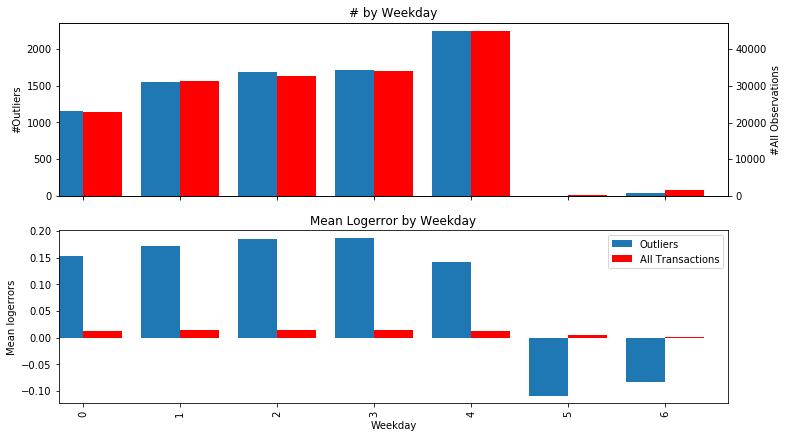

In [204]:
fig = plt.figure(figsize=(12, 7)) # Create matplotlib figure

ax = fig.add_subplot(211) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.
outliers['logerror'].groupby(outliers["transactiondate"].dt.weekday).count().plot(kind='bar', ax=ax, width=.4, position=1)
df['logerror'].groupby(df["transactiondate"].dt.weekday).count().plot(kind='bar', ax=ax2, width=.4, position=0, color='r')
ax.set_xlabel(' ')
ax.set_ylabel('#Outliers')
ax2.set_ylabel('#All Observations')
plt.title('# by Weekday')

ax3 = fig.add_subplot(212)
outliers['logerror'].groupby(outliers["transactiondate"].dt.weekday).mean().plot(kind='bar', ax=ax3, width=.4, position=1)
df['logerror'].groupby(df["transactiondate"].dt.weekday).mean().plot(kind='bar', ax=ax3, width=.4, position=0, color='r')
ax3.set_xlabel('Weekday')
ax3.set_ylabel('Mean logerrors')
plt.title('Mean Logerror by Weekday')
ax3.legend(['Outliers', 'All Transactions'])

plt.show()

- Most transactions are settled in weekdays, especially on Friday. There is very few transaction during weekends.

- The logerrors of weekdays are all positive and not much different.

- It is interesting that the weekend transactions have negative logerrors, though the mean logerrors of all weekend transactions are still slightly positive.

- The positive logerrors of weekday transactions means that weekend transasctions are overall over-estimated by Zillow.

- The negative logerrors of weekend transactions means that weekend transasctions are overall under-estimated by Zillow (or to say, home are sold in a premium during weekends).

#### Extract weekday & month feature
Since the month & weekday are good predictors for logerror, we will add new columns to specify them.

In [205]:
months_since_2015 = lambda d1: (d1.year - 2016) * 12 + d1.month # define a lambda function to calculate months
df['MonthSince2015'] =df['transactiondate'].apply(months_since_2015) # take time factor into account
df['Month'] = df["transactiondate"].dt.month # Jan=1, Feb=2, Mar=3, ...
df['Weekday'] = df["transactiondate"].dt.weekday + 1 # M=1, T=2, W=3, ... (add one to avoid confusion)

m1 = smf.ols(formula='logerror ~ MonthSince2015 + C(Month) + C(Weekday)', data=df).fit()
print(m1.summary())

                            OLS Regression Results                            
Dep. Variable:               logerror   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     9.583
Date:                Sun, 17 Dec 2017   Prob (F-statistic):           3.03e-27
Time:                        22:10:58   Log-Likelihood:                 63649.
No. Observations:              167888   AIC:                        -1.273e+05
Df Residuals:                  167869   BIC:                        -1.271e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0151      0.002     

- It is not surprising that the intercept is positive w/ a zeroish p-value, which is consistent with our perception that the logerrors are overall right-skewed

- The M_since_2015 time factor has zero p-value, which proves that the logerror is increasing over time. The increasing trend is legitimate because as the value of properties increase, the errors should be incremental

- Note the negative Month factors near 2nd quarter (March - July)

- Even w/ the positive intercept, the Weekday_7 factor still plays a role. It is consistent with our earlier finding of weekend undervaluation, though the t-test excludes Saturday for us.

#### Add dummies
Based on our findings from statistical test, we will keep the M_since_2015 parameter and add two dummy parameters: Quarter_2 (including Apr, May, Jun) and Sunday.

In [206]:
# Create dummies (one dummy column is removed to avoid collinearity)
df['Q2'] = [(month <= 6 and month > 3) for month in df['Month']]
df['Weekday7'] = [weekday == 7 for weekday in df['Weekday']]

df = df.drop(['Month', 'Weekday'], 1)
numerical_var.append('MonthSince2015')
categorical_var.extend(('Q2', 'Weekday7'))

# Re-extract outliers
outliers = df[abs(df.logerror) > abs_pct_95]
outliers_1 = df[abs(df.logerror) > 1]

### Numerical variables
We will start w/ a look at correlation coefficients of logerror w/ each numerical feature

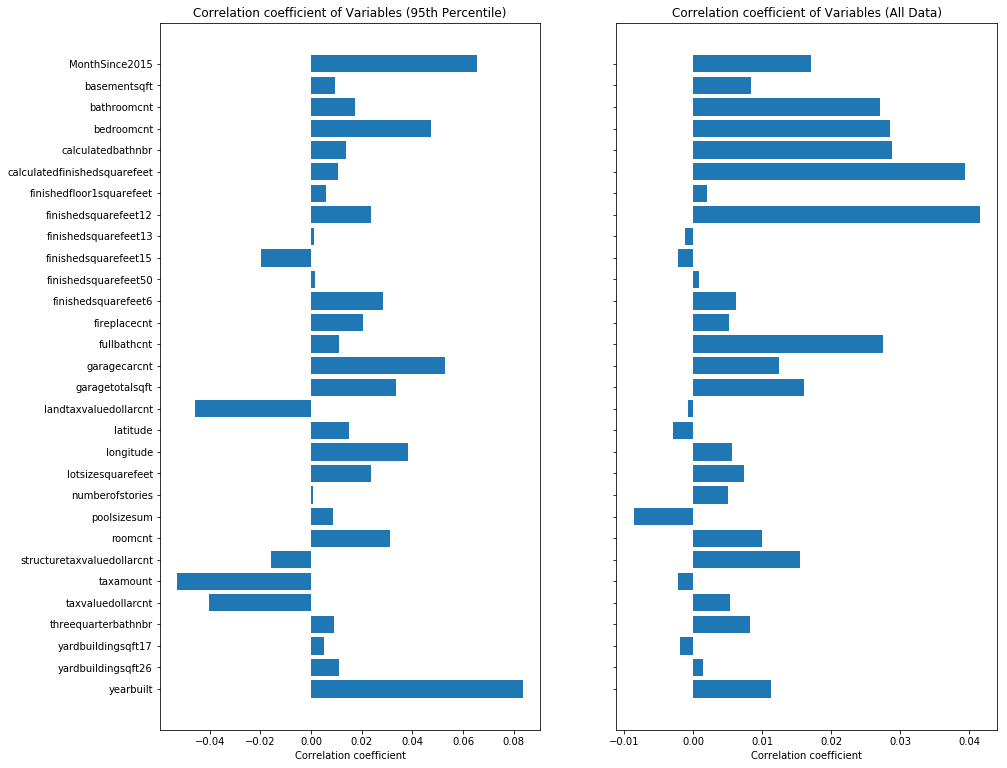

In [207]:
labels = []
corr_df = []
corr_ot = []
corr_ot_1 = []
count_df = []
count_ot = []
count_ot_1 = []

for col in numerical_var:
        labels.append(col)
        corr_df.append(df[[col, 'logerror']].corr().iloc[0, 1])
        corr_ot.append(outliers[[col, 'logerror']].corr().iloc[0, 1])
        corr_ot_1.append(outliers_1[[col, 'logerror']].corr().iloc[0, 1])
        count_df.append(df[col].count())
        count_ot.append(outliers[col].count())
        count_ot_1.append(outliers_1[col].count())
        

corr_count = pd.DataFrame({'col_labels':labels, \
                        'corr_df':corr_df, 'corr_outlier':corr_ot, 'corr_outlier_1':corr_ot_1, \
                        'count_df':count_df, 'count_outlier':count_ot, 'count_outlier_1':count_ot_1})
corr_count = corr_count.sort_values('col_labels', ascending=False)


f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15,13))
ind = np.arange(len(labels))

rects = ax1.barh(ind, np.array(corr_count.corr_outlier.values))
ax1.set_yticks(ind)
ax1.set_yticklabels(corr_count.col_labels.values, rotation='horizontal')
ax1.set_xlabel("Correlation coefficient")
ax1.set_title("Correlation coefficient of Variables (95th Percentile)")

rects2 = ax2.barh(ind, np.array(corr_count.corr_df.values))
ax2.set_yticks(ind)
ax2.set_yticklabels(corr_count.col_labels.values, rotation='horizontal')
ax2.set_xlabel("Correlation coefficient")
ax2.set_title("Correlation coefficient of Variables (All Data)")
plt.show()


- The lack of data results in abnormally high/low correlations. For example, "basementsqft", "yardbuildingsqft26", "finished squaredfeet13" have less than 15 samples.

- Lack of data means lack of representiveness. We need to take one step back and compare them with the entire data set. If the observations with similar features have low logerrors, then the high correlationships are not helpful.

- Comparing the logerrors, we can find some features w/ contradicting correlations between the two barcharts. Especially the ones w/ very few samples.

In [208]:
corr_count = corr_count.set_index('col_labels').sort_index(ascending=True)
corr_count

,corr_df,corr_outlier,corr_outlier_1,count_df,count_outlier,count_outlier_1
col_labels,,,,,,
MonthSince2015,0.017081,0.065502,1.115279e-01,167888,8391,694
basementsqft,0.008313,0.009443,2.859183e-16,167888,8391,694
bathroomcnt,0.027024,0.017274,9.288983e-02,167888,8391,694
bedroomcnt,0.028498,0.047439,1.183145e-01,167888,8391,694
calculatedbathnbr,0.028814,0.013767,1.204169e-01,167888,8391,694
calculatedfinishedsquarefeet,0.039344,0.010577,1.439523e-01,167888,8391,694
finishedfloor1squarefeet,0.001921,0.005997,6.402440e-02,167888,8391,694
finishedsquarefeet12,0.041471,0.023825,1.491824e-01,167888,8391,694
finishedsquarefeet13,-0.001228,0.001170,3.343009e-16,167888,8391,694


#### Take a look at the logerror distribution of features

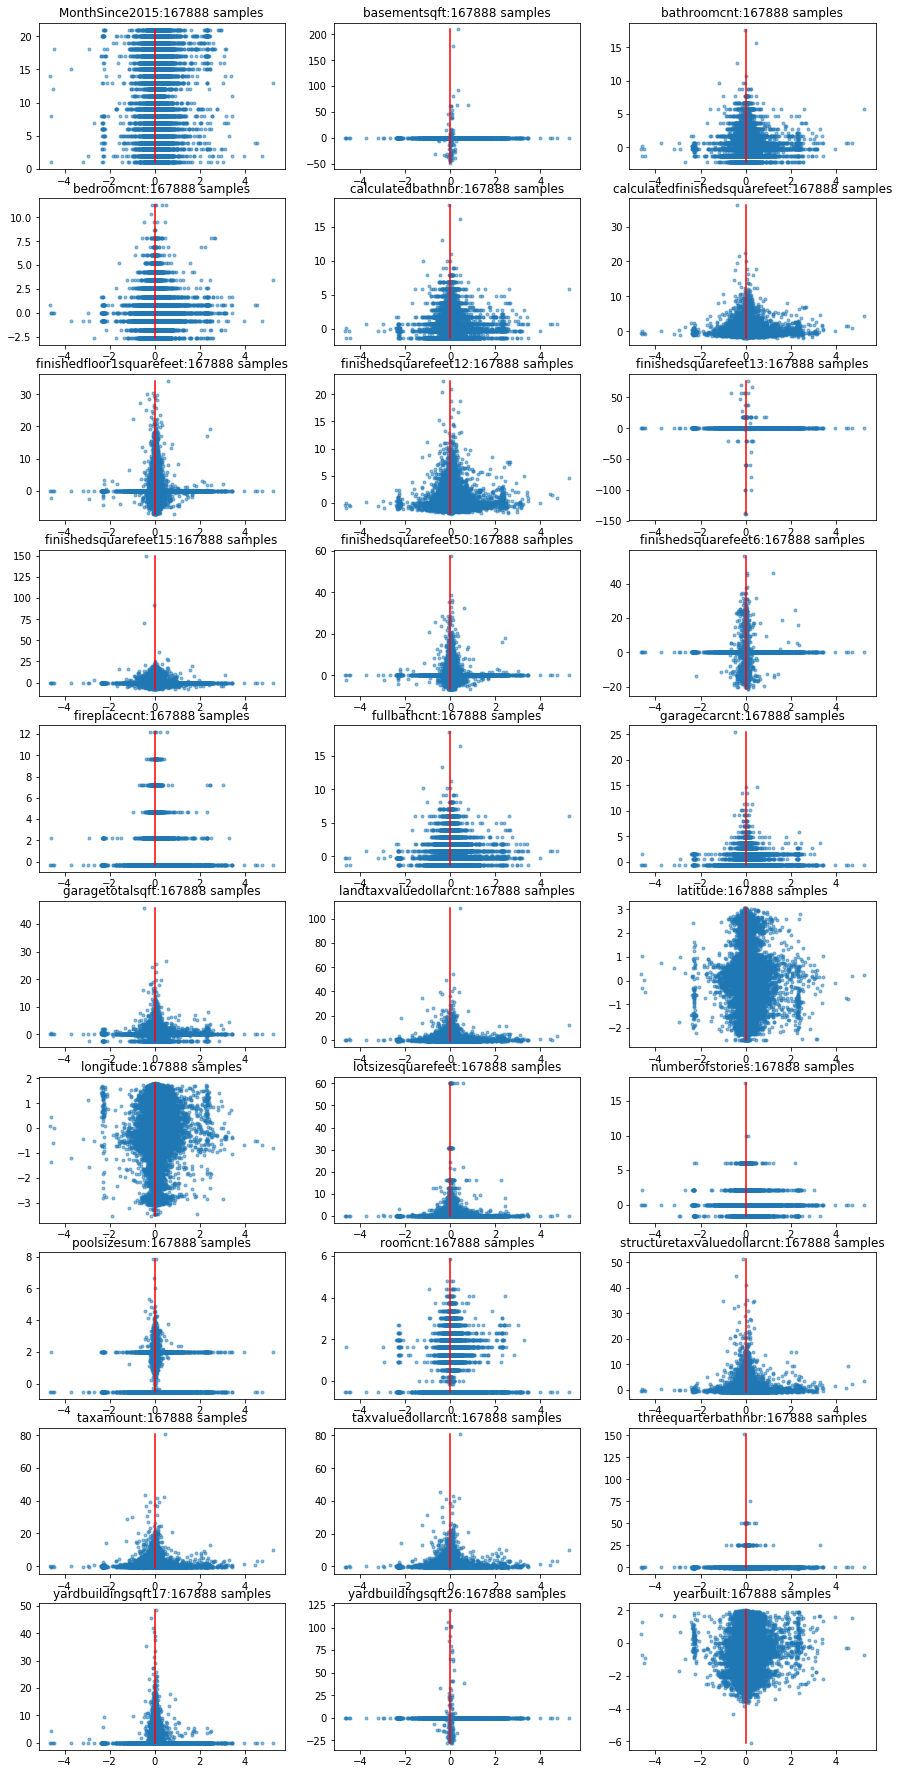

In [209]:
col = sorted(numerical_var)
yaxis = df.logerror

plt.figure(figsize=(15, 35))

for i in range(len(col)):
    plt.subplot(11, 3, i + 1)
    xaxis = df[col[i]]
    plt.scatter(x=yaxis, y=xaxis, marker='.', alpha=.5)
    plt.plot([0, 0], [xaxis.min(), xaxis.max()], color='r')
    plt.title(col[i] + ':'+ str(int(xaxis.describe()[0])) + ' samples')

- From the plots above, we can see the positive skewness and assymetry of logerrors.

- Next step we will do a statistical test to check if any of them are useful. 

- Given these plots, a linear regression should meets our needs.

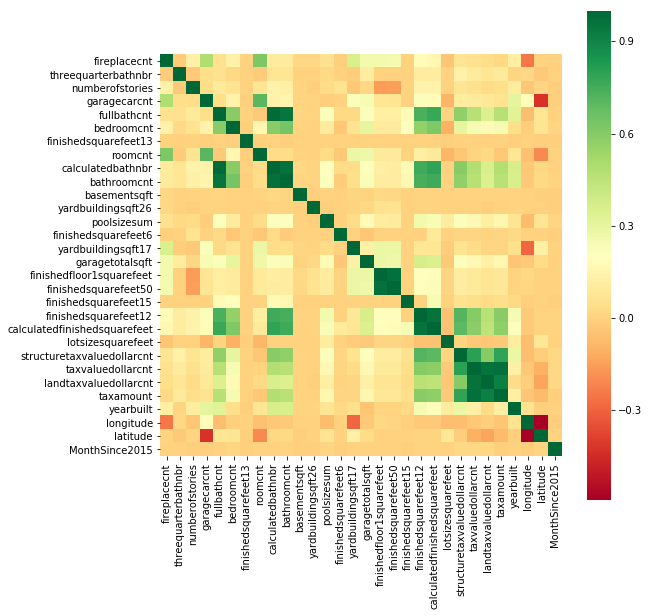

In [210]:
plt.figure(figsize=(9, 9))
sns.heatmap(df[numerical_var].corr(), square=True, cmap='RdYlGn')
plt.show()

There are a few features highly correlated with each other. We may need to remove some of them later.

In [211]:
# Create an input string to read all numerical params
all_columns = " + ".join(numerical_var)
my_formula = "logerror ~" + all_columns

m2 = smf.ols(formula=my_formula, data=df).fit()
print(m2.summary())

                            OLS Regression Results                            
Dep. Variable:               logerror   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     27.53
Date:                Sun, 17 Dec 2017   Prob (F-statistic):          5.61e-154
Time:                        22:13:50   Log-Likelihood:                 63975.
No. Observations:              167888   AIC:                        -1.279e+05
Df Residuals:                  167857   BIC:                        -1.276e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

#### Geographic features

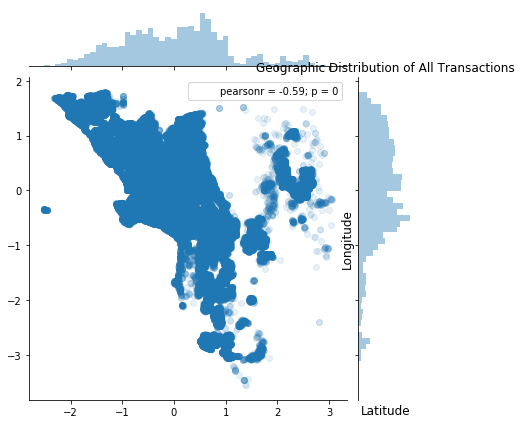

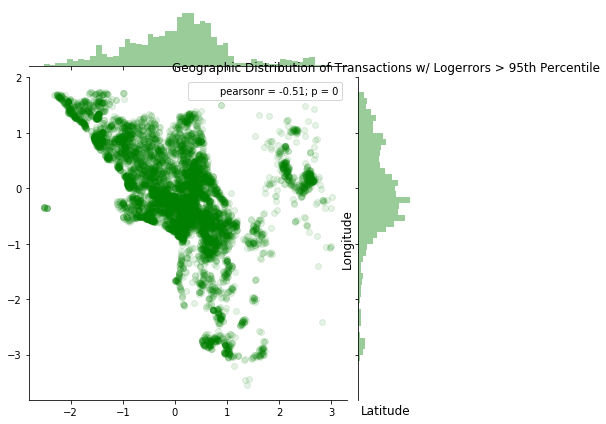

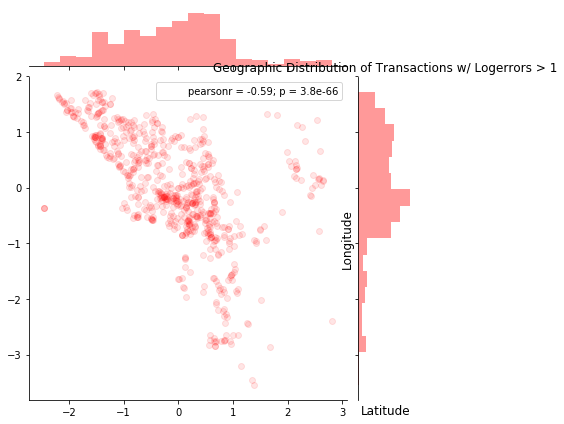

In [212]:
sns.jointplot(x=df.latitude.values, y=df.longitude.values, size=6, alpha=.1)
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
plt.title('Geographic Distribution of All Transactions')

sns.jointplot(x=outliers.latitude.values, y=outliers.longitude.values, size=6, alpha=.1, color='green')
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
plt.title('Geographic Distribution of Transactions w/ Logerrors > 95th Percentile')

sns.jointplot(x=outliers_1.latitude.values, y=outliers_1.longitude.values, size=6, alpha=.1, color='red')
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
plt.title('Geographic Distribution of Transactions w/ Logerrors > 1')

plt.show()

The 1st plot looks like the LA area because the data come from real estate properties in three LA counties (Los Angeles, Orange and Ventura, California) from Jan 2016 to Sep 2017. The blue dot to the left is probably Channel Island.

The histograms on the x- and y-axis look similar through the three plots. The similarity corresponds with the high-pvalues of longitude and latitude.

#### We will keep the features that w/ small p-values.

In [213]:
# Remove parameters w/ minimal contirbution to the model
mask = m2.pvalues < .1
numerical_var_new = list(mask[mask].reset_index()['index'][1:])
print('New list of numerical parameters:\n'+str(numerical_var_new))

New list of numerical parameters:
['fireplacecnt', 'numberofstories', 'garagecarcnt', 'bedroomcnt', 'roomcnt', 'calculatedbathnbr', 'bathroomcnt', 'basementsqft', 'poolsizesum', 'finishedsquarefeet6', 'finishedsquarefeet50', 'finishedsquarefeet15', 'finishedsquarefeet12', 'calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount', 'MonthSince2015']


In [214]:
df_numerical = df[numerical_var_new]
df_numerical.describe()

,fireplacecnt,numberofstories,garagecarcnt,bedroomcnt,roomcnt,calculatedbathnbr,bathroomcnt,basementsqft,poolsizesum,finishedsquarefeet6,finishedsquarefeet50,finishedsquarefeet15,finishedsquarefeet12,calculatedfinishedsquarefeet,lotsizesquarefeet,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,MonthSince2015
count,1.678880e+05,1.678880e+05,1.678880e+05,1.678880e+05,1.678880e+05,1.678880e+05,1.678880e+05,1.678880e+05,1.678880e+05,1.678880e+05,1.678880e+05,1.678880e+05,1.678880e+05,1.678880e+05,1.678880e+05,1.678880e+05,1.678880e+05,1.678880e+05,1.678880e+05,167888.000000
mean,8.895563e-15,1.050653e-16,4.771680e-15,2.315464e-15,1.377793e-15,2.670908e-15,2.030090e-15,1.068252e-18,1.205630e-14,-1.032996e-17,-9.166750e-18,3.504221e-17,-8.835199e-17,8.080769e-17,4.807117e-17,-4.292767e-17,1.185292e-17,-6.031541e-17,1.473019e-17,11.032921
std,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,6.170169
min,-3.169252e-01,-1.686146e+00,-6.512045e-01,-2.647258e+00,-5.237061e-01,-1.349720e+00,-2.286594e+00,-4.808977e+01,-5.030950e-01,-2.153187e+01,-6.836761e+00,-8.118252e+00,-1.948922e+00,-1.894384e+00,-2.539758e-01,-8.418013e-01,-7.841477e-01,-6.482539e-01,-8.275309e-01,1.000000
25%,-3.169252e-01,-2.322956e-17,-6.512045e-01,-9.066365e-01,-5.237061e-01,-3.213949e-01,-2.880548e-01,1.089813e-18,-5.030950e-01,9.618656e-18,3.819367e-18,-4.046857e-17,-6.261294e-01,-6.329757e-01,-2.038620e-01,-4.641230e-01,-4.478524e-01,-4.602736e-01,-4.423682e-01,6.000000
50%,-3.169252e-01,-2.322956e-17,-6.512045e-01,-3.632560e-02,-5.237061e-01,-3.213949e-01,-2.880548e-01,1.089813e-18,-5.030950e-01,9.618656e-18,3.819367e-18,-4.046857e-17,-2.119217e-01,-2.480488e-01,-1.898838e-01,-2.278252e-01,-2.035323e-01,-2.043179e-01,-2.062169e-01,10.000000
75%,-3.169252e-01,-2.322956e-17,1.522948e+00,8.339853e-01,-5.237061e-01,7.069302e-01,7.112146e-01,1.089813e-18,-5.030950e-01,9.618656e-18,3.819367e-18,-4.046857e-17,3.013840e-01,3.405374e-01,-6.500600e-02,1.354448e-01,1.349048e-01,1.490094e-01,1.280863e-01,17.000000
max,1.218142e+01,1.757249e+01,2.543862e+01,1.127772e+01,5.856554e+00,1.818846e+01,1.769879e+01,2.095590e+02,7.856059e+00,5.578241e+01,5.732920e+01,1.493683e+02,2.246595e+01,3.610568e+01,6.008033e+01,5.132714e+01,8.060867e+01,1.092098e+02,8.049216e+01,21.000000


### Categorical variables

##### Feature selection

In [215]:
df[categorical_var].nunique()

decktypeid                      1
hashottuborspa                  2
poolcnt                         2
pooltypeid10                    1
pooltypeid2                     1
pooltypeid7                     1
storytypeid                     1
fireplaceflag                   2
taxdelinquencyflag              1
buildingclasstypeid             3
assessmentyear                  3
fips                            4
regionidcounty                  4
typeconstructiontypeid          5
airconditioningtypeid           7
architecturalstyletypeid        7
buildingqualitytypeid          13
heatingorsystemtypeid          13
unitcnt                        14
propertylandusetypeid          15
propertycountylandusecode      91
propertyzoningdesc           2347
regionidcity                  179
regionidzip                   391
regionidneighborhood          506
Q2                              2
Weekday7                        2
dtype: int64

#### Calculate p-values of categorical features (take ~40 mins)

In [218]:
tic = time.clock()

all_columns = ") + C(".join(categorical_var)
my_formula = "logerror ~ C(" + all_columns + ")"

m3 = smf.ols(formula=my_formula, data=df).fit()
#print(m3.summary())

toc = time.clock()
print('Elapsed time: ' + str(toc - tic) + ' seconds.')

Elapsed time: 2340.571859 seconds.


##### Select features w/ low p-values

In [219]:
# Use mask to filter p-values
mask = m3.pvalues < .1
categorical_var_all = list(m3.pvalues.reset_index()['index'][1:])
categorical_var_lowp = list(mask[mask].reset_index()['index'][1:])

# Extract vars by substring
all_vars = [myString[myString.find("(")+1:myString.find(")")] for myString in categorical_var_all]
lowp_vars = [myString[myString.find("(")+1:myString.find(")")] for myString in categorical_var_lowp]

# Calculate percent of low-pvalue labels in each feature
[unique, counts] = np.unique(all_vars, return_counts=True)
freq_all = pd.DataFrame([unique, counts]).T
freq_all.columns=['Feature', 'Freq_All']

[unique2, counts2] = np.unique(lowp_vars, return_counts=True)
freq_lowp = pd.DataFrame([unique2, counts2]).T
freq_lowp.columns=['Feature', 'Freq_Low_P']

freq = freq_lowp.merge(freq_all, how='outer').fillna(0)
freq['Pct_Low_P'] = round(freq['Freq_Low_P'] / freq['Freq_All'] * 100, 2)
freq = freq.set_index('Feature').sort_values('Pct_Low_P', ascending=False)
freq

,Freq_Low_P,Freq_All,Pct_Low_P
Feature,,,
Q2,1,1,100.00
poolcnt,1,1,100.00
Weekday7,1,1,100.00
regionidcity,166,178,93.26
assessmentyear,1,2,50.00
buildingclasstypeid,1,2,50.00
unitcnt,4,13,30.77
buildingqualitytypeid,3,12,25.00
regionidzip,57,390,14.62


#### Choose useful features and create dummies
We will keep the features of which at least 10% percent labels have low p-values

In [234]:
categorical_var_new = freq[freq.Pct_Low_P > 10.0].reset_index()['Feature']

dummy_cols = pd.get_dummies(df[categorical_var_new], drop_first=True)
dummy_cols.head()

,Q2,Weekday7,poolcnt_1.0,regionidcity_4406.0,regionidcity_5465.0,regionidcity_5534.0,regionidcity_6021.0,regionidcity_6285.0,regionidcity_6395.0,regionidcity_6822.0,...,regionidzip_97319.0,regionidzip_97323.0,regionidzip_97324.0,regionidzip_97328.0,regionidzip_97329.0,regionidzip_97330.0,regionidzip_97331.0,regionidzip_97344.0,regionidzip_399675.0,regionidzip_missing
0,False,False,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,False,False,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,False,False,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,False,False,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,False,False,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [232]:
df2 = pd.concat([df.logerror, df_numerical, dummy_cols], axis=1)
df2.head()

,logerror,fireplacecnt,numberofstories,garagecarcnt,bedroomcnt,roomcnt,calculatedbathnbr,bathroomcnt,basementsqft,poolsizesum,...,regionidzip_97319.0,regionidzip_97323.0,regionidzip_97324.0,regionidzip_97328.0,regionidzip_97329.0,regionidzip_97330.0,regionidzip_97331.0,regionidzip_97344.0,regionidzip_399675.0,regionidzip_missing
0,0.0276,-0.316925,-2.322956e-17,-0.651205,-0.036326,-0.523706,-0.321395,-0.288055,1.089813e-18,-0.503095,...,0,0,0,0,0,0,0,0,0,0
1,-0.1684,-0.316925,-2.322956e-17,1.522948,0.833985,-0.523706,1.221093,1.210849,1.089813e-18,-0.503095,...,0,0,0,0,0,0,0,0,0,0
2,-0.0040,-0.316925,-2.322956e-17,-0.651205,-0.906636,-0.523706,0.706930,0.711215,1.089813e-18,-0.503095,...,0,0,0,0,0,0,0,0,0,0
3,0.0218,-0.316925,-2.322956e-17,-0.651205,-0.906636,-0.523706,-0.321395,-0.288055,1.089813e-18,-0.503095,...,0,0,0,0,0,0,0,0,0,0
4,-0.0050,-0.316925,2.165581e+00,1.522948,0.833985,2.311965,0.192768,0.211580,1.089813e-18,1.975661,...,0,0,0,0,0,0,0,0,0,0


#### Check how the predictors performs

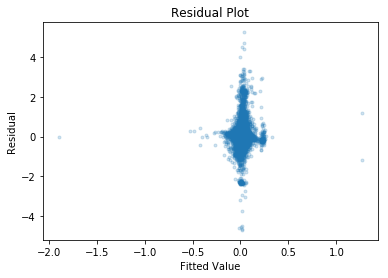

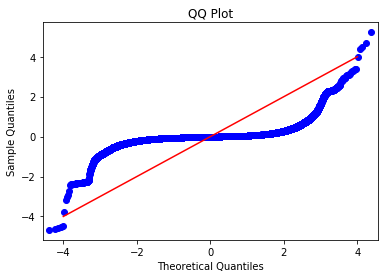

In [235]:
# Create an input string to read all numerical params
num_columns = ' + '.join(numerical_var_new)
cat_columns = ') + C('.join(categorical_var_new)
my_formula = 'logerror ~ ' + num_columns + ' + C(' + cat_columns + ')'

m4 = smf.ols(formula=my_formula, data=df).fit()
#print(m4.summary())

# Residual plot
plt.scatter(m4.fittedvalues, m4.resid, marker='.', alpha=.2)
plt.xlabel('Fitted Value')
plt.ylabel('Residual')
plt.title('Residual Plot')
plt.show()

# QQ Plot
sm.qqplot(m4.resid)
plt.title('QQ Plot')
plt.plot([-4, 4], [-4, 4], c='red')
plt.show()

- No significant trend can be identified in the residual plot

- The shape of QQ plot corresponds with the heavy center and thin tails of logerror distribution

# 4. Analysis using machine learning

#### Create target variable and predictors

In [236]:
X = df2.drop(['logerror'], axis = 1, inplace = False)
y = df2.logerror

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=42)

#### Fit a linear regression regressor

In [237]:
# Create the regressor
reg = LinearRegression()

# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(reg, X_train, y_train, cv=5)

# Print the 5-fold cross-validation scores
print('The 5-fold cross-validation scores are: ' + str(cv_scores))
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

The 5-fold cross-validation scores are: [ -1.40800595e+15  -2.50803061e+16  -4.52187053e+14  -4.67872269e+16
  -2.95343979e+11]
Average 5-Fold CV Score: -1.4745604271325716e+16


#### A funciton to display Cross-Validation scores against Alpha

In [238]:
def display_plot(cv_scores, cv_scores_std):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(alpha_space, cv_scores)

    std_error = cv_scores_std / np.sqrt(10)

    ax.fill_between(alpha_space, cv_scores + std_error, cv_scores - std_error, alpha=0.2)
    ax.set_ylabel('CV Score +/- Std Error')
    ax.set_xlabel('Alpha')
    ax.axhline(np.max(cv_scores), linestyle='--', color='.5')
    ax.set_xlim([alpha_space[0], alpha_space[-1]])
    ax.set_xscale('log')
    plt.show()

#### Create an grid to find optimal combo of alpha and l1 ratio (~17 hrs)

In [314]:
tic = time.clock()

# Create the hyperparameter grid
alpha_space = np.logspace(-10, -0, 11)
l1_space = np.linspace(0, 1, 11)
param_grid = {'alpha':alpha_space, 'l1_ratio': l1_space}

# Instantiate the ElasticNet regressor: elastic_net
my_alpha = alpha_space[5]
elastic_net = ElasticNet(alpha=my_alpha)

# Setup the GridSearchCV object: gm_cv
gm_cv = GridSearchCV(elastic_net, param_grid, cv=5)

# Fit it to the training data
gm_cv.fit(X_train, y_train)

print("Tuned ElasticNet l1 ratio: {}".format(gm_cv.best_params_))

toc = time.clock()
print('Elapsed time: ' + str(toc - tic) + ' seconds.')

Tuned ElasticNet l1 ratio: {'alpha': 3.5938136638046256e-05, 'l1_ratio': 0.77777777777777768}
Elapsed time: 63874.32109 seconds.


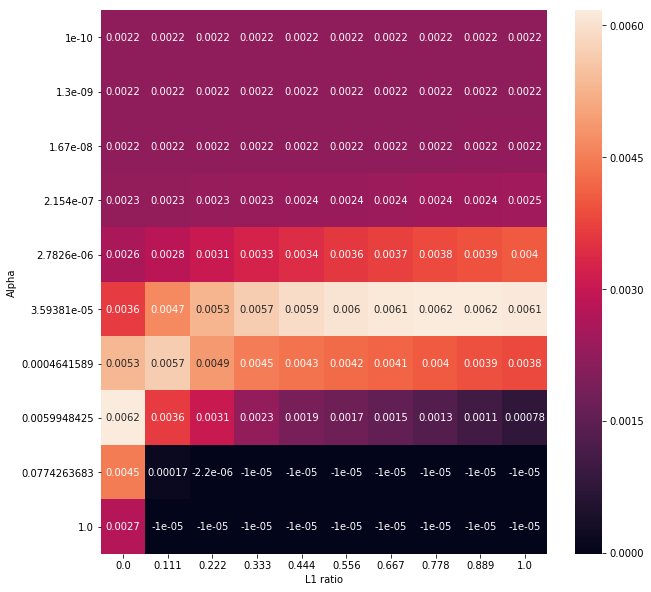

The best score of the grid is 0.00617063801823 w/ alpha = 3.5938136638e-05 and l1 ratio = 0.777777777778


In [365]:
grid_score = gm_cv.cv_results_['mean_test_score'].reshape(10, 10)

plt.figure(figsize=[10, 10])
ax = sns.heatmap(grid_score, annot=True, xticklabels=np.round(l1_space, 3), yticklabels=np.round(alpha_space, 10))
plt.xlabel('L1 ratio')
plt.ylabel('Alpha')
plt.show()

print('The best score of the grid is ' + str(gm_cv.best_score_ ) + ' w/ alpha = ' + \
     str(gm_cv.best_estimator_.alpha) + ' and l1 ratio = ' + \
      str(gm_cv.best_estimator_.l1_ratio))

#### Alpha Tuning
As shown in the heatmap, we have a higher sensitivity to Alpha, so we will focus on Alpha Tunning.

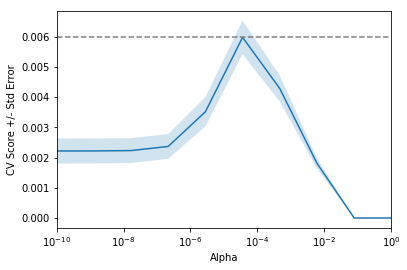

Elapsed time: 4526.293204 seconds.


In [239]:
tic = time.clock()

# Setup the array of alphas and lists to store scores
alpha_space = np.logspace(-10, 0, 10)
elastic_net_scores = []
elastic_net_scores_std = []

# Create a elastic net regressor
elastic_net = ElasticNet()

# Compute scores over range of alphas
for alpha in alpha_space:

    # Specify the alpha value to use: ridge.alpha
    elastic_net.alpha = alpha
    
    # Perform 10-fold CV: elastic_net_cv_scores
    elastic_net_cv_scores = cross_val_score(elastic_net, X_train, y_train, cv=5)
    
    # Append the mean of elastic_net_cv_scores to elastic_net_scores
    elastic_net_scores.append(np.mean(elastic_net_cv_scores))
    
    # Append the std of elastic_net_cv_scores to elastic_net_scores
    elastic_net_scores_std.append(np.std(elastic_net_cv_scores))

# Display the plot
display_plot(elastic_net_scores, elastic_net_scores_std)

toc = time.clock()
print('Elapsed time: ' + str(toc - tic) + ' seconds.')

#### Further Tune Alpha (~70 mins)
Fromt the plot above, we can see that the Alpha of best CV score is between 10e-5 and 10e-4. Let's find the optimal Alpha by giving a narrower alpha space

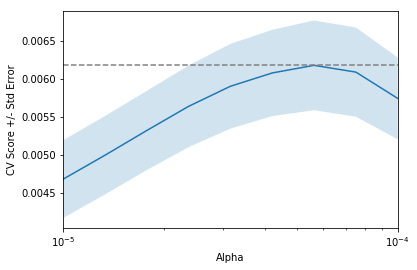

Elapsed time: 4100.920915999999 seconds.


In [240]:
tic = time.clock()

# Setup the array of alphas and lists to store scores
alpha_space = np.logspace(-5, -4, 9)
elastic_net_scores = []
elastic_net_scores_std = []

# Create a elastic net regressor
elastic_net = ElasticNet()

# Compute scores over range of alphas
for alpha in alpha_space:

    # Specify the alpha value to use
    elastic_net.alpha = alpha
    
    # Perform 10-fold CV: elastic_net_cv_scores
    elastic_net_cv_scores = cross_val_score(elastic_net, X_train, y_train, cv=5)
    
    # Append the mean of elastic_net_cv_scores to elastic_net_scores
    elastic_net_scores.append(np.mean(elastic_net_cv_scores))
    
    # Append the std of elastic_net_cv_scores to elastic_net_scores
    elastic_net_scores_std.append(np.std(elastic_net_cv_scores))

# Display the plot
display_plot(elastic_net_scores, elastic_net_scores_std)

toc = time.clock()
print('Elapsed time: ' + str(toc - tic) + ' seconds.')

From the plot above, the optimal Alpha is the 5th item in alpha_space (4.2169650342858222e-05)

#### Predict w/ test data

In [366]:
# Instantiate a regressor
my_l1_ratio = gm_cv.best_estimator_.l1_ratio
my_alpha = gm_cv.best_estimator_.alpha
elastic_net = ElasticNet(alpha=my_alpha, l1_ratio=my_l1_ratio)

# Fit the regressor to the training data
elastic_net.fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred = elastic_net.predict(X_test)

# Compute and print score
elastic_net_score = elastic_net.score(X_test, y_test)
print("Score: {}".format(elastic_net_score))

Score: 0.00611992458052979


#### Show parameters w/ non-zero coefs

In [367]:
params_coef =  pd.DataFrame([X.columns, elastic_net.coef_]).T
params = params_coef[0][params_coef[1] != 0]
params_clean = []

for param in params:
    if param.find("_") == -1:
        params_clean.append(param)
    else:
        params_clean.append(param[0:param.find('_')])

params_unique = set(params_clean)

print('The parameters selected by Elastic Net w/ Alpha = ' + str(my_alpha) + ' and L1 ratio = ' + \
      str(my_l1_ratio) + ' include:\n' + str(params_unique))

The parameters selected by Elastic Net w/ Alpha = 3.5938136638e-05 and L1 ratio = 0.777777777778 include:
{'Q2', 'lotsizesquarefeet', 'fireplacecnt', 'basementsqft', 'MonthSince2015', 'finishedsquarefeet12', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'garagecarcnt', 'unitcnt', 'roomcnt', 'finishedsquarefeet6', 'regionidzip', 'Weekday7', 'assessmentyear', 'poolsizesum', 'finishedsquarefeet50', 'taxamount', 'numberofstories', 'regionidcity', 'buildingqualitytypeid', 'calculatedbathnbr', 'bedroomcnt', 'bathroomcnt', 'finishedsquarefeet15'}


# 5. Conclusion
After our analysis of these different features, I find the following variables useful in predicting the logerrors of Zestimate: 

'Q2', 'lotsizesquarefeet', 'fireplacecnt', 'basementsqft', 'MonthSince2015', 'finishedsquarefeet12', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'garagecarcnt', 'unitcnt', 'roomcnt', 'finishedsquarefeet6', 'regionidzip', 'Weekday7', 'assessmentyear', 'poolsizesum', 'finishedsquarefeet50', 'taxamount', 'numberofstories', 'regionidcity', 'buildingqualitytypeid', 'calculatedbathnbr', 'bedroomcnt', 'bathroomcnt', 'finishedsquarefeet15'.

Note: 'Q2', 'Weekday7', 'MonthSince2015' are customized variable created from the 'transactiondate' feature.

Overall, Zillow did a good job in predicting most home values, and in most cases prediction errors are fairly small. In some cases, the homes are sold in a premium/discount. I think those transactions are probably caused by individual reasons and the predictors fail to catch those outliers. In order to minimize those outliers, Zillow should add more predictors and reduce the amount of missing data while collecting data.